In [1]:
import numpy as np
import pandas as pd
import os
import time

# plots
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# dicom
import pydicom as dicom

In [2]:
# warning handling
import warnings
warnings.filterwarnings('ignore')

In [3]:
# show files
!ls -l '../input/rsna-2024-lumbar-spine-degenerative-classification'

total 5312
-rw-r--r--    1 nobody nogroup    2545 May 17 03:32 sample_submission.csv
drwxr-xr-x    3 nobody nogroup       0 May 17 03:32 test_images
-rw-r--r--    1 nobody nogroup     136 May 17 03:32 test_series_descriptions.csv
-rw-r--r--    1 nobody nogroup  568972 May 17 03:32 train.csv
drwxr-xr-x 1977 nobody nogroup       0 May 17 03:34 train_images
-rw-r--r--    1 nobody nogroup 4642067 May 17 03:34 train_label_coordinates.csv
-rw-r--r--    1 nobody nogroup  213642 May 17 03:34 train_series_descriptions.csv


In [4]:
# configs
default_color_1 = 'orange'

In [5]:
# read data
df_train_main = pd.read_csv('../input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
df_train_label = pd.read_csv('../input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
df_train_desc = pd.read_csv('../input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
df_test_desc = pd.read_csv('../input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')
df_sub = pd.read_csv('../input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')

# Data Preparation

Main Table

In [6]:
# structure
df_train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

In [7]:
# preview
df_train_main.head()

study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
0   4003253                 Normal/Mild                 Normal/Mild   
1   4646740                 Normal/Mild                 Normal/Mild   
2   7143189                 Normal/Mild                 Normal/Mild   
3   8785691                 Normal/Mild                 Normal/Mild   
4  10728036                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
0                 Normal/Mild                 Normal/Mild   
1                    Moderate                      Severe   
2                 Normal/Mild                 Normal/Mild   
3                 Normal/Mild                 Normal/Mild   
4                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
0                 Normal/Mild                           Normal/Mild   
1                 Normal/Mild                           Normal/Mild   
2                 Normal/Mild                           Normal/Mild   
3                 Normal/Mild                           Normal/Mild   
4                 Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l2_l3 left_neural_foraminal_narrowing_l3_l4  \
0                           Normal/Mild                           Normal/Mild   
1                           Normal/Mild                           Normal/Mild   
2                           Normal/Mild                           Normal/Mild   
3                           Normal/Mild                           Normal/Mild   
4                           Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l4_l5  ... left_subarticular_stenosis_l1_l2  \
0                              Moderate  ...                      Normal/Mild   
1                              Moderate  ...                      Normal/Mild   
2                           Normal/Mild  ...                      Normal/Mild   
3                              Moderate  ...                      Normal/Mild   
4                           Normal/Mild  ...                      Normal/Mild   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   
1                           Severe                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                          Moderate   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   
1                          Moderate                          Moderate   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                          Moderate   

  right_subarticular_stenosis_l5_s1  
0                       Normal/Mild  


Label

In [8]:
# structure
df_train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   study_id         48692 non-null  int64  
 1   series_id        48692 non-null  int64  
 2   instance_number  48692 non-null  int64  
 3   condition        48692 non-null  object 
 4   level            48692 non-null  object 
 5   x                48692 non-null  float64
 6   y                48692 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.6+ MB


In [9]:
# preview
df_train_label.head()

study_id  series_id  instance_number              condition  level  \
0   4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1   4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2   4003253  702807833                8  Spinal Canal Stenosis  L3/L4   
3   4003253  702807833                8  Spinal Canal Stenosis  L4/L5   
4   4003253  702807833                8  Spinal Canal Stenosis  L5/S1   

            x           y  
0  322.831858  227.964602  
1  320.571429  295.714286  
2  323.030303  371.818182  
3  335.292035  427.327434  
4  353.415929  483.964602

In [10]:
# look at categories
for f in ['instance_number','condition','level']:
    print(df_train_label[f].value_counts())
    print()

instance_number
8      3615
11     3517
10     3396
5      3288
12     3180
       ... 
118       1
96        1
73        1
83        1
117       1
Name: count, Length: 101, dtype: int64

condition
Left Neural Foraminal Narrowing     9860
Right Neural Foraminal Narrowing    9859
Spinal Canal Stenosis               9753
Right Subarticular Stenosis         9612
Left Subarticular Stenosis          9608
Name: count, dtype: int64

level
L3/L4    9858
L4/L5    9858
L5/S1    9845
L2/L3    9661
L1/L2    9470
Name: count, dtype: int64



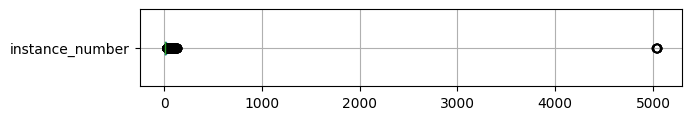

In [11]:
# numerical plot for instance number
plt.figure(figsize=(7,1))
df_train_label.instance_number.plot(kind='box', vert=False)
plt.grid()
plt.show()

In [12]:
# look at few rows with the very high instance numbers
df_train_label[df_train_label.instance_number>150]

study_id   series_id  instance_number                    condition  \
28959  2581283971  2683794967             5031   Left Subarticular Stenosis   
28960  2581283971  2683794967             5031  Right Subarticular Stenosis   
28961  2581283971  2683794967             5039   Left Subarticular Stenosis   
28962  2581283971  2683794967             5039  Right Subarticular Stenosis   
28963  2581283971  2683794967             5046   Left Subarticular Stenosis   
28964  2581283971  2683794967             5046  Right Subarticular Stenosis   

       level           x           y  
28959  L3/L4  164.410886  190.815709  
28960  L3/L4  134.110855  188.871083  
28961  L4/L5  155.146032  184.370593  
28962  L4/L5  125.905727  186.136040  
28963  L5/S1  160.785508  176.314198  
28964  L5/S1  127.729089  181.577635

In [13]:
# condition vs level
pd.crosstab(df_train_label.condition, df_train_label.level)

level                             L1/L2  L2/L3  L3/L4  L4/L5  L5/S1
condition                                                          
Left Neural Foraminal Narrowing    1972   1972   1972   1972   1972
Left Subarticular Stenosis         1810   1892   1971   1971   1964
Right Neural Foraminal Narrowing   1972   1972   1971   1972   1972
Right Subarticular Stenosis        1812   1891   1971   1971   1967
Spinal Canal Stenosis              1904   1934   1973   1972   1970

In [14]:
# structure
df_train_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6294 entries, 0 to 6293
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   study_id            6294 non-null   int64 
 1   series_id           6294 non-null   int64 
 2   series_description  6294 non-null   object
dtypes: int64(2), object(1)
memory usage: 147.6+ KB


In [15]:
# preview
df_train_desc.head()

study_id   series_id series_description
0   4003253   702807833   Sagittal T2/STIR
1   4003253  1054713880        Sagittal T1
2   4003253  2448190387           Axial T2
3   4646740  3201256954           Axial T2
4   4646740  3486248476        Sagittal T1

series_description
Axial T2            2340
Sagittal T1         1980
Sagittal T2/STIR    1974
Name: count, dtype: int64


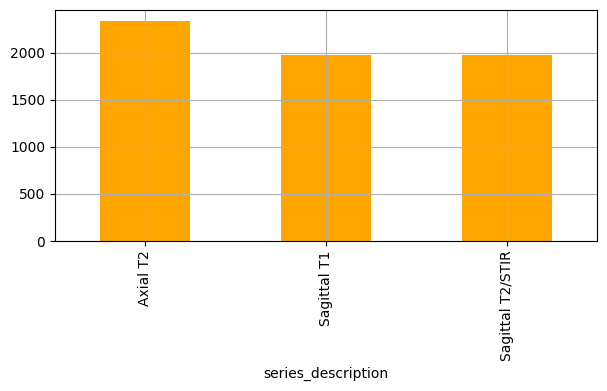

In [16]:
# look at categories
counts = df_train_desc.series_description.value_counts()
print(counts)
plt.figure(figsize=(7,3))
counts.plot(kind='bar', color=default_color_1)
plt.grid()
plt.show()

In [17]:
# join first two tables
df_train_step_1 = pd.merge(left=df_train_label, right=df_train_main, how='left', on='study_id').reset_index(drop=True)
df_train_step_1.head()

study_id  series_id  instance_number              condition  level  \
0   4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1   4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2   4003253  702807833                8  Spinal Canal Stenosis  L3/L4   
3   4003253  702807833                8  Spinal Canal Stenosis  L4/L5   
4   4003253  702807833                8  Spinal Canal Stenosis  L5/S1   

            x           y spinal_canal_stenosis_l1_l2  \
0  322.831858  227.964602                 Normal/Mild   
1  320.571429  295.714286                 Normal/Mild   
2  323.030303  371.818182                 Normal/Mild   
3  335.292035  427.327434                 Normal/Mild   
4  353.415929  483.964602                 Normal/Mild   

  spinal_canal_stenosis_l2_l3 spinal_canal_stenosis_l3_l4  ...  \
0                 Normal/Mild                 Normal/Mild  ...   
1                 Normal/Mild                 Normal/Mild  ...   
2                 Normal/Mild                 Normal/Mild  ...   
3                 Normal/Mild                 Normal/Mild  ...   
4                 Normal/Mild                 Normal/Mild  ...   

  left_subarticular_stenosis_l1_l2 left_subarticular_stenosis_l2_l3  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l3_l4 left_subarticular_stenosis_l4_l5  \
0                      Normal/Mild                         Moderate   
1                      Normal/Mild                         Moderate   
2                      Normal/Mild                         Moderate   
3                      Normal/Mild                         Moderate   
4                      Normal/Mild                         Moderate   

  left_subarticular_stenosis_l5_s1 right_subarticular_stenosis_l1_l2  \
0                      Normal/Mild                       Normal/Mild   
1                      Normal/Mild                       Normal/Mild   
2                      Normal/Mild                       Normal/Mild   
3                      Normal/Mild                       Normal/Mild   
4                      Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l2_l3 right_subarticular_stenosis_l3_l4  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l4_l5 right_subarticular_stenosis_l5_s1  
0                       Normal/Mild                       Normal/Mild  
1                       Normal/Mild                       Normal/Mild  
2                       Normal/Mild                       Normal/Mild  
3                       Normal/Mild                       Normal/Mild  
4                       Normal/Mild                       Normal/Mild  

[5 rows x 32 columns]

In [18]:
# join with third table
df_train = pd.merge(left=df_train_step_1, right=df_train_desc, how='left', on=['study_id', 'series_id']).reset_index(drop=True)
df_train.head()

study_id  series_id  instance_number              condition  level  \
0   4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1   4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2   4003253  702807833                8  Spinal Canal Stenosis  L3/L4   
3   4003253  702807833                8  Spinal Canal Stenosis  L4/L5   
4   4003253  702807833                8  Spinal Canal Stenosis  L5/S1   

            x           y spinal_canal_stenosis_l1_l2  \
0  322.831858  227.964602                 Normal/Mild   
1  320.571429  295.714286                 Normal/Mild   
2  323.030303  371.818182                 Normal/Mild   
3  335.292035  427.327434                 Normal/Mild   
4  353.415929  483.964602                 Normal/Mild   

  spinal_canal_stenosis_l2_l3 spinal_canal_stenosis_l3_l4  ...  \
0                 Normal/Mild                 Normal/Mild  ...   
1                 Normal/Mild                 Normal/Mild  ...   
2                 Normal/Mild                 Normal/Mild  ...   
3                 Normal/Mild                 Normal/Mild  ...   
4                 Normal/Mild                 Normal/Mild  ...   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   
1                         Moderate                      Normal/Mild   
2                         Moderate                      Normal/Mild   
3                         Moderate                      Normal/Mild   
4                         Moderate                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l5_s1 series_description  
0                       Normal/Mild   Sagittal T2/STIR  
1                       Normal/Mild   Sagittal T2/STIR  
2                       Normal/Mild   Sagittal T2/STIR  
3                       Normal/Mild   Sagittal T2/STIR  
4                       Normal/Mild   Sagittal T2/STIR  

[5 rows x 33 columns]

In [19]:
# convert ids to categorical
df_train.study_id = df_train.study_id.astype('category')
df_train.series_id = df_train.series_id.astype('category')

# EDA

In [20]:
# combined table - basic stats
df_train.describe(include='all').T

count  unique  \
study_id                                48692.0  1974.0   
series_id                               48692.0  6291.0   
instance_number                         48692.0     NaN   
condition                                 48692       5   
level                                     48692       5   
x                                       48692.0     NaN   
y                                       48692.0     NaN   
spinal_canal_stenosis_l1_l2               48692       3   
spinal_canal_stenosis_l2_l3               48692       3   
spinal_canal_stenosis_l3_l4               48692       3   
spinal_canal_stenosis_l4_l5               48692       3   
spinal_canal_stenosis_l5_s1               48692       3   
left_neural_foraminal_narrowing_l1_l2     48662       3   
left_neural_foraminal_narrowing_l2_l3     48662       3   
left_neural_foraminal_narrowing_l3_l4     48662       3   
left_neural_foraminal_narrowing_l4_l5     48662       3   
left_neural_foraminal_narrowing_l5_s1     48662       3   
right_neural_foraminal_narrowing_l1_l2    48512       3   
right_neural_foraminal_narrowing_l2_l3    48512       3   
right_neural_foraminal_narrowing_l3_l4    48512       3   
right_neural_foraminal_narrowing_l4_l5    48512       3   
right_neural_foraminal_narrowing_l5_s1    48512       3   
left_subarticular_stenosis_l1_l2          45184       3   
left_subarticular_stenosis_l2_l3          47041       3   
left_subarticular_stenosis_l3_l4          48627       3   
left_subarticular_stenosis_l4_l5          48623       3   
left_subarticular_stenosis_l5_s1          48440       3   
right_subarticular_stenosis_l1_l2         45258       3   
right_subarticular_stenosis_l2_l3         47045       3   
right_subarticular_stenosis_l3_l4         48652       3   
right_subarticular_stenosis_l4_l5         48648       3   
right_subarticular_stenosis_l5_s1         48537       3   
series_description                        48692       3   

                                                                    top  \
study_id                                                      4003253.0   
series_id                                                  3951475160.0   
instance_number                                                     NaN   
condition                               Left Neural Foraminal Narrowing   
level                                                             L3/L4   
x                                                                   NaN   
y                                                                   NaN   
spinal_canal_stenosis_l1_l2                                 Normal/Mild   
spinal_canal_stenosis_l2_l3                                 Normal/Mild   
spinal_canal_stenosis_l3_l4                                 Normal/Mild   
spinal_canal_stenosis_l4_l5                                 Normal/Mild   
spinal_canal_stenosis_l5_s1                                 Normal/Mild   
left_neural_foraminal_narrowing_l1_l2                       Normal/Mild   
left_neural_foraminal_narrowing_l2_l3                       Normal/Mild   
left_neural_foraminal_narrowing_l3_l4                       Normal/Mild   
left_neural_foraminal_narrowing_l4_l5                       Normal/Mild   
left_neural_foraminal_narrowing_l5_s1                       Normal/Mild   
right_neural_foraminal_narrowing_l1_l2                      Normal/Mild   
right_neural_foraminal_narrowing_l2_l3                      Normal/Mild   
right_neural_foraminal_narrowing_l3_l4                      Normal/Mild   
right_neural_foraminal_narrowing_l4_l5                      Normal/Mild   
right_neural_foraminal_narrowing_l5_s1                      Normal/Mild   
left_subarticular_stenosis_l1_l2                            Normal/Mild   
left_subarticular_stenosis_l2_l3                            Normal/Mild   
left_subarticular_stenosis_l3_l4                            Normal/Mild   
left_subarticular_stenosis_l4_l5                            Normal/Mild   
left_subar

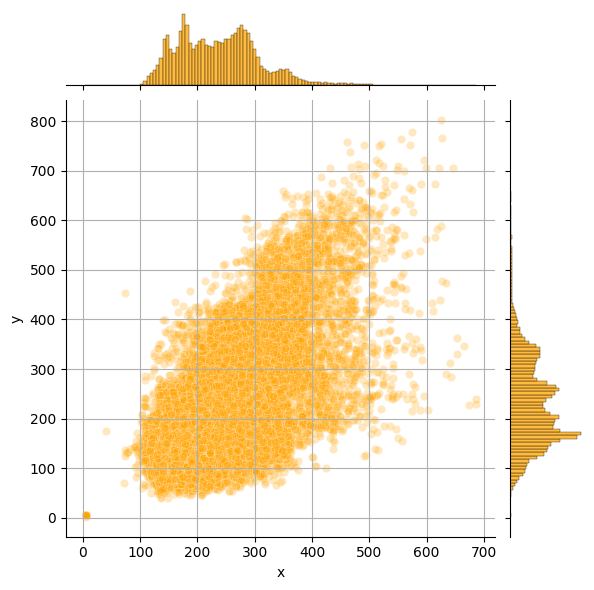

In [21]:
# plot coordinates
sns.jointplot(data=df_train, x='x', y='y', 
              color=default_color_1, alpha=0.25)
plt.grid()
plt.show()

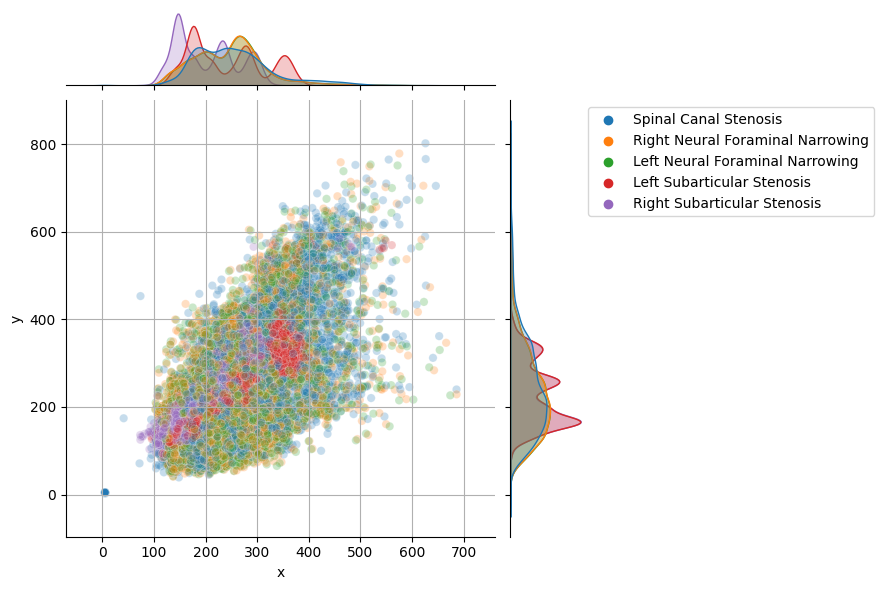

In [22]:
# plot coordinates - colored by condition
ax = sns.jointplot(data=df_train, x='x', y='y', 
                   hue='condition', alpha=0.25)
plt.legend(bbox_to_anchor=(1.2,1), loc=2)
plt.grid()
plt.show()

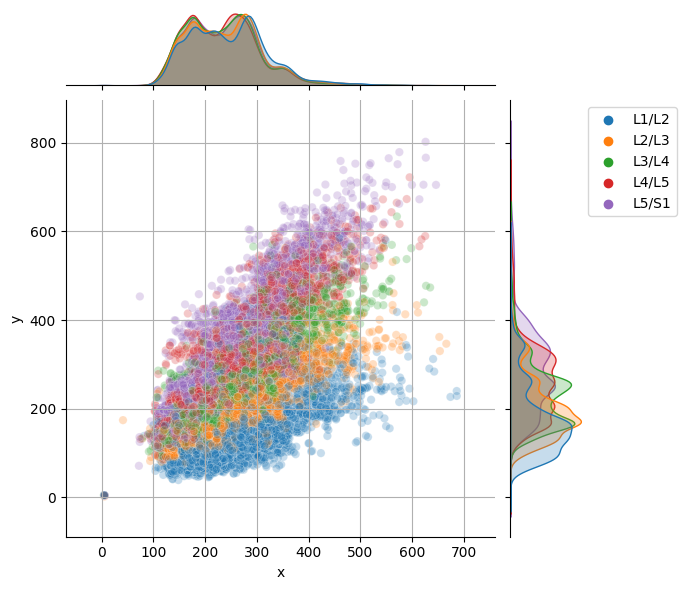

In [23]:
# plot coordinates - colored by level
sns.jointplot(data=df_train, x='x', y='y', 
              hue='level', alpha=0.25)
plt.legend(bbox_to_anchor=(1.2,1), loc=2)
plt.grid()
plt.show()

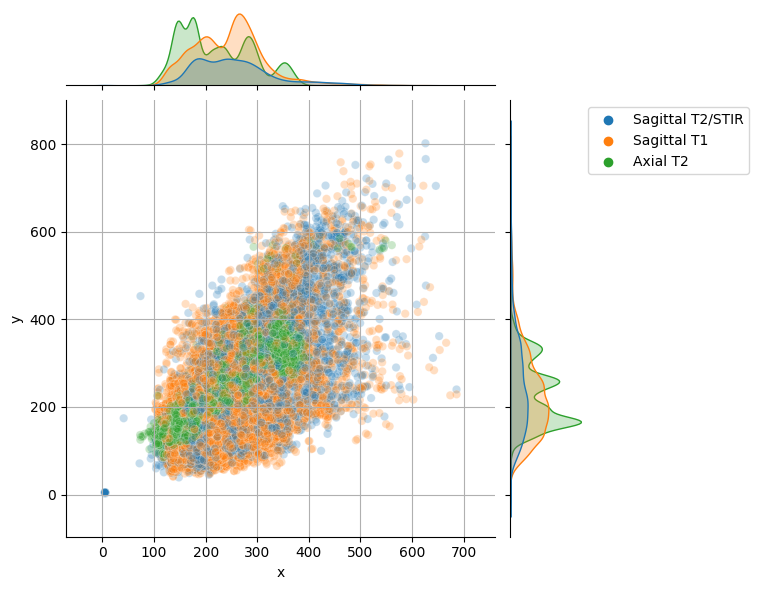

In [24]:
# plot coordinates - colored by description
sns.jointplot(data=df_train, x='x', y='y', 
              hue='series_description', alpha=0.25)
plt.legend(bbox_to_anchor=(1.2,1), loc=2)
plt.grid()
plt.show()

Distributing Label data

In [25]:
labels = df_train_main.columns.drop('study_id').tolist()
print(labels)

['spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1', 'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1']


spinal_canal_stenosis_l1_l2
Normal/Mild    0.955420
Moderate       0.033941
Severe         0.010638
Name: proportion, dtype: float64


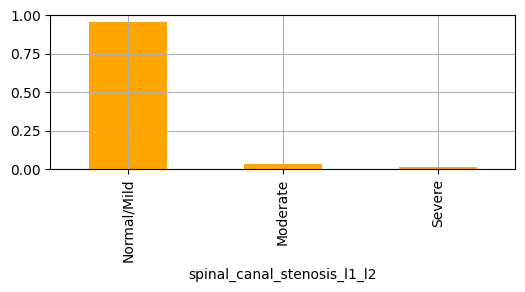

spinal_canal_stenosis_l2_l3
Normal/Mild    0.896657
Moderate       0.076494
Severe         0.026849
Name: proportion, dtype: float64


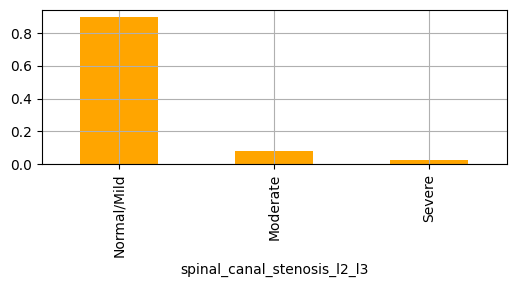

spinal_canal_stenosis_l3_l4
Normal/Mild    0.821682
Moderate       0.116515
Severe         0.061803
Name: proportion, dtype: float64


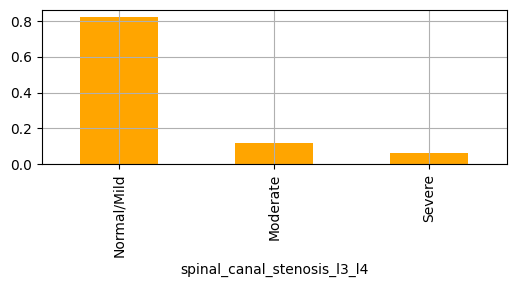

spinal_canal_stenosis_l4_l5
Normal/Mild    0.750760
Severe         0.129179
Moderate       0.120061
Name: proportion, dtype: float64


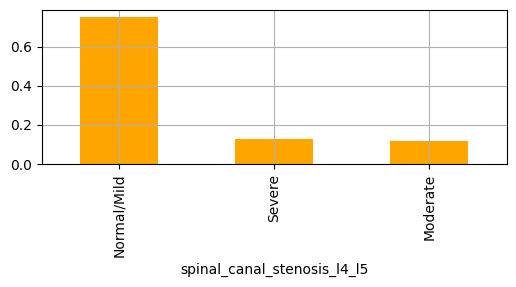

spinal_canal_stenosis_l5_s1
Normal/Mild    0.964539
Moderate       0.025836
Severe         0.009625
Name: proportion, dtype: float64


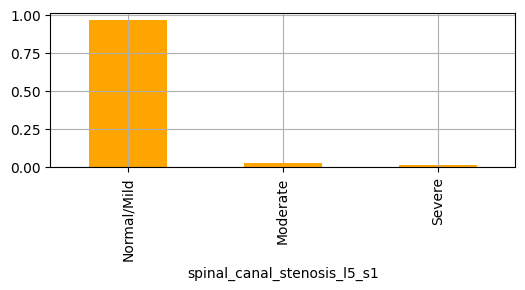

left_neural_foraminal_narrowing_l1_l2
Normal/Mild    0.967055
Moderate       0.031931
Severe         0.001014
Name: proportion, dtype: float64


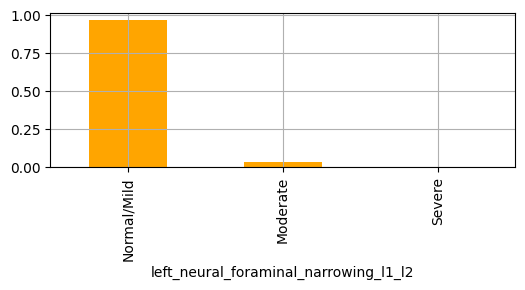

left_neural_foraminal_narrowing_l2_l3
Normal/Mild    0.907755
Moderate       0.086670
Severe         0.005575
Name: proportion, dtype: float64


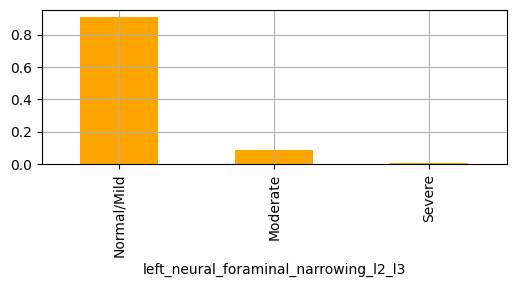

left_neural_foraminal_narrowing_l3_l4
Normal/Mild    0.771414
Moderate       0.208312
Severe         0.020274
Name: proportion, dtype: float64


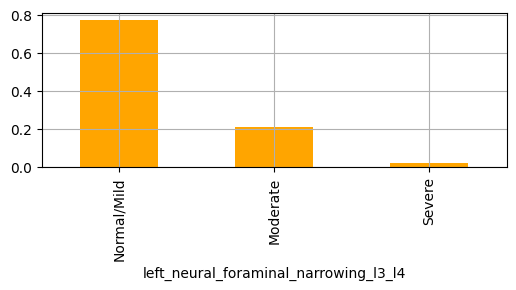

left_neural_foraminal_narrowing_l4_l5
Normal/Mild    0.610238
Moderate       0.318804
Severe         0.070958
Name: proportion, dtype: float64


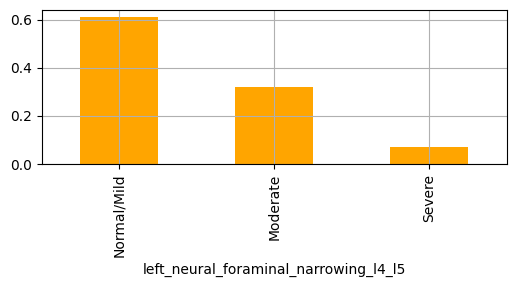

left_neural_foraminal_narrowing_l5_s1
Normal/Mild    0.632032
Moderate       0.263558
Severe         0.104410
Name: proportion, dtype: float64


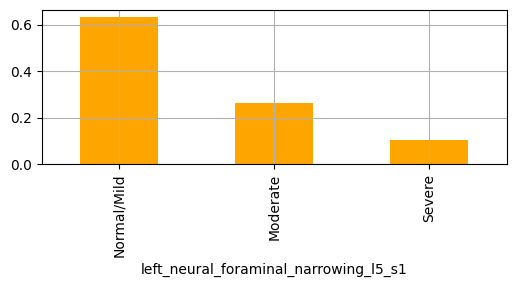

right_neural_foraminal_narrowing_l1_l2
Normal/Mild    0.961362
Moderate       0.032028
Severe         0.006609
Name: proportion, dtype: float64


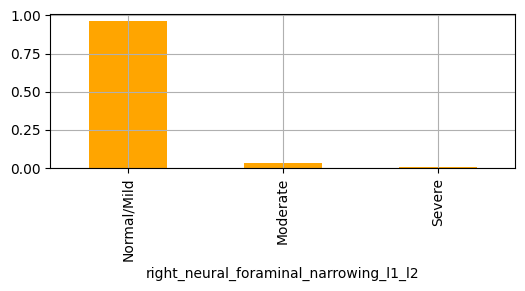

right_neural_foraminal_narrowing_l2_l3
Normal/Mild    0.911540
Moderate       0.085409
Severe         0.003050
Name: proportion, dtype: float64


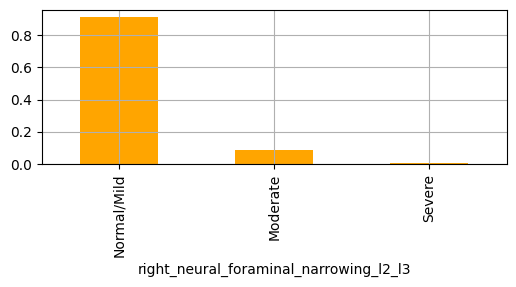

right_neural_foraminal_narrowing_l3_l4
Normal/Mild    0.768683
Moderate       0.210473
Severe         0.020844
Name: proportion, dtype: float64


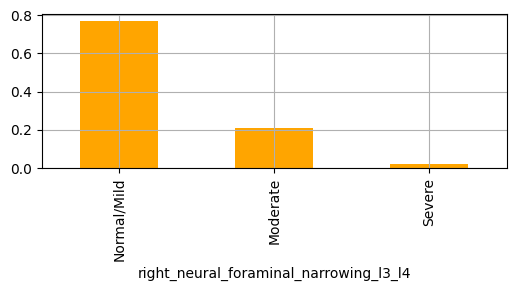

right_neural_foraminal_narrowing_l4_l5
Normal/Mild    0.614133
Moderate       0.319776
Severe         0.066090
Name: proportion, dtype: float64


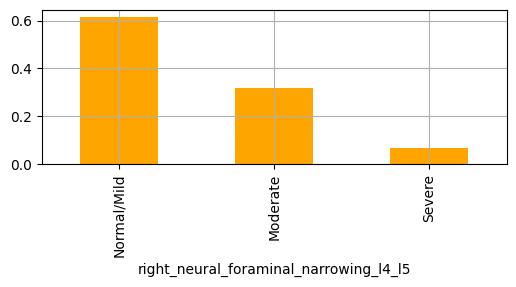

right_neural_foraminal_narrowing_l5_s1
Normal/Mild    0.651246
Moderate       0.252161
Severe         0.096594
Name: proportion, dtype: float64


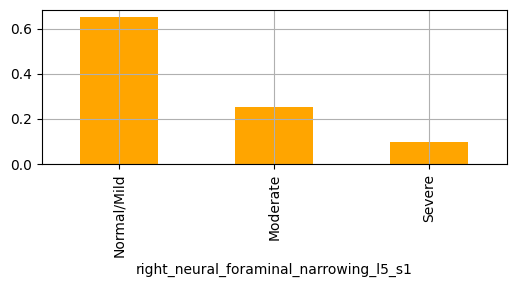

left_subarticular_stenosis_l1_l2
Normal/Mild    0.933186
Moderate       0.051353
Severe         0.015461
Name: proportion, dtype: float64


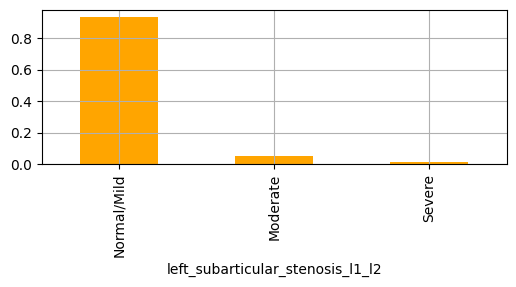

left_subarticular_stenosis_l2_l3
Normal/Mild    0.821447
Moderate       0.134707
Severe         0.043846
Name: proportion, dtype: float64


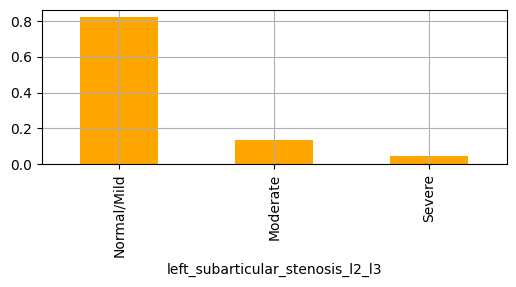

left_subarticular_stenosis_l3_l4
Normal/Mild    0.671400
Moderate       0.230223
Severe         0.098377
Name: proportion, dtype: float64


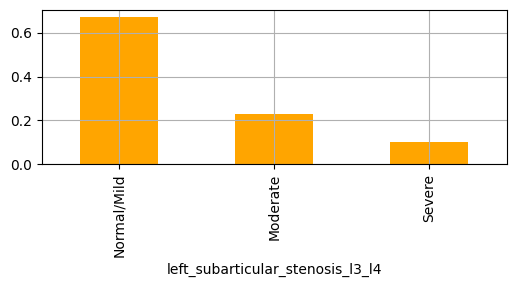

left_subarticular_stenosis_l4_l5
Normal/Mild    0.449797
Moderate       0.316430
Severe         0.233773
Name: proportion, dtype: float64


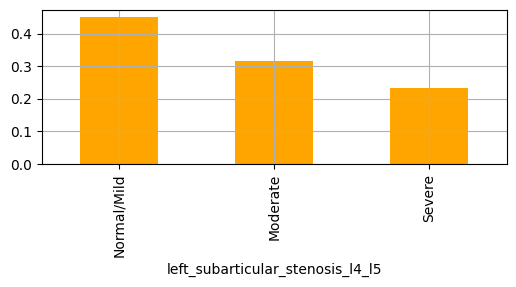

left_subarticular_stenosis_l5_s1
Normal/Mild    0.716904
Moderate       0.208248
Severe         0.074847
Name: proportion, dtype: float64


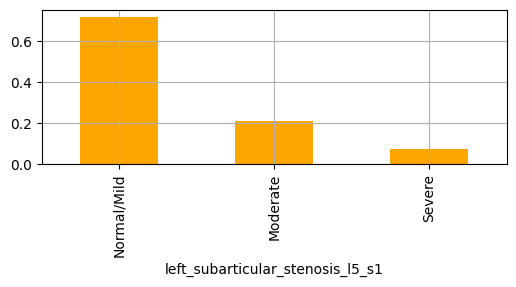

right_subarticular_stenosis_l1_l2
Normal/Mild    0.926130
Moderate       0.060639
Severe         0.013230
Name: proportion, dtype: float64


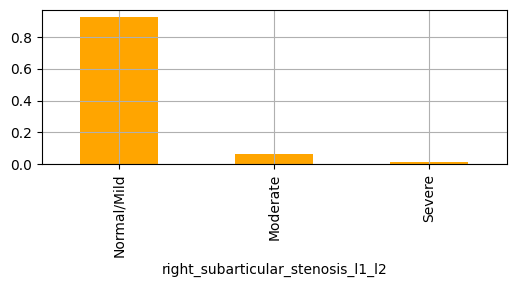

right_subarticular_stenosis_l2_l3
Normal/Mild    0.833069
Moderate       0.128368
Severe         0.038563
Name: proportion, dtype: float64


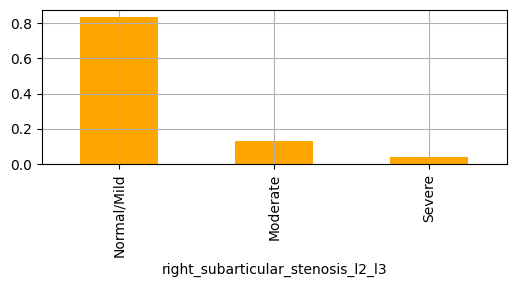

right_subarticular_stenosis_l3_l4
Normal/Mild    0.670046
Moderate       0.230106
Severe         0.099848
Name: proportion, dtype: float64


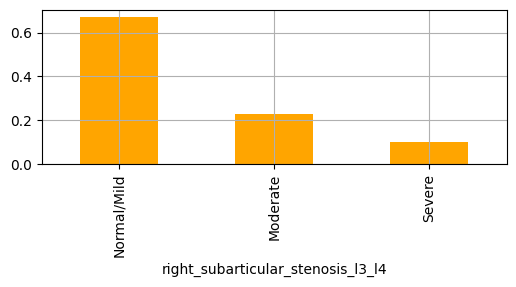

right_subarticular_stenosis_l4_l5
Normal/Mild    0.451597
Moderate       0.315256
Severe         0.233147
Name: proportion, dtype: float64


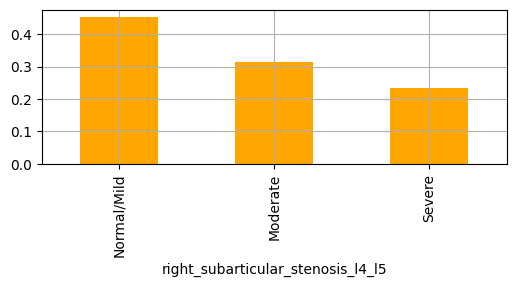

right_subarticular_stenosis_l5_s1
Normal/Mild    0.710874
Moderate       0.201220
Severe         0.087907
Name: proportion, dtype: float64


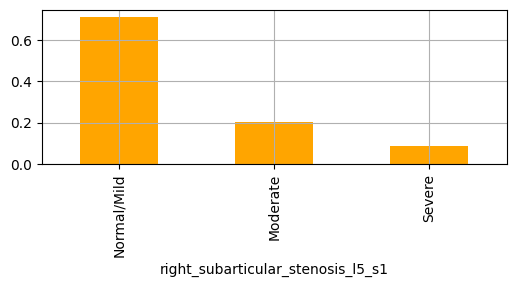

In [26]:
# plot label distributions
for l in labels:
    plt.figure(figsize=(6,2))
    counts = df_train_main[l].value_counts(normalize=True)
    print(counts)
    counts.plot(kind='bar', color=default_color_1)
    plt.grid()
    plt.show()

In [27]:
# create frequency table for the labels
freqs = pd.DataFrame(labels, columns=['label'])
freqs['p1'] = 1.0
freqs['p2'] = 0.0
freqs['p3'] = 0.0

for l in labels:
    rel_counts = df_train_main[l].value_counts(normalize=True)
    freqs.loc[freqs.label==l, 'p1'] = rel_counts['Normal/Mild']
    freqs.loc[freqs.label==l, 'p2'] = rel_counts['Moderate']
    freqs.loc[freqs.label==l, 'p3'] = rel_counts['Severe']

In [28]:
# show frequency table
freqs

label        p1        p2        p3
0              spinal_canal_stenosis_l1_l2  0.955420  0.033941  0.010638
1              spinal_canal_stenosis_l2_l3  0.896657  0.076494  0.026849
2              spinal_canal_stenosis_l3_l4  0.821682  0.116515  0.061803
3              spinal_canal_stenosis_l4_l5  0.750760  0.120061  0.129179
4              spinal_canal_stenosis_l5_s1  0.964539  0.025836  0.009625
5    left_neural_foraminal_narrowing_l1_l2  0.967055  0.031931  0.001014
6    left_neural_foraminal_narrowing_l2_l3  0.907755  0.086670  0.005575
7    left_neural_foraminal_narrowing_l3_l4  0.771414  0.208312  0.020274
8    left_neural_foraminal_narrowing_l4_l5  0.610238  0.318804  0.070958
9    left_neural_foraminal_narrowing_l5_s1  0.632032  0.263558  0.104410
10  right_neural_foraminal_narrowing_l1_l2  0.961362  0.032028  0.006609
11  right_neural_foraminal_narrowing_l2_l3  0.911540  0.085409  0.003050
12  right_neural_foraminal_narrowing_l3_l4  0.768683  0.210473  0.020844
13  right_neural_foraminal_narrowing_l4_l5  0.614133  0.319776  0.066090
14  right_neural_foraminal_narrowing_l5_s1  0.651246  0.252161  0.096594
15        left_subarticular_stenosis_l1_l2  0.933186  0.051353  0.015461
16        left_subarticular_stenosis_l2_l3  0.821447  0.134707  0.043846
17        left_subarticular_stenosis_l3_l4  0.671400  0.230223  0.098377
18        left_subarticular_stenosis_l4_l5  0.449797  0.316430  0.233773
19        left_subarticular_stenosis_l5_s1  0.716904  0.208248  0.074847
20       right_subarticular_stenosis_l1_l2  0.926130  0.060639  0.013230
21       right_subarticular_stenosis_l2_l3  0.833069  0.128368  0.038563
22       right_subarticular_stenosis_l3_l4  0.670046  0.230106  0.099848
23       right_subarticular_stenosis_l4_l5  0.451597  0.315256  0.233147
24       right_subarticular_stenosis_l5_s1  0.710874  0.201220  0.087907

In [29]:
# make combined table available for download
df_train.to_csv('df_train.csv', index=False)

In [30]:
my_study = 4003253
df_ex = df_train[df_train.study_id==my_study]
df_ex

study_id   series_id  instance_number                         condition  \
0   4003253   702807833                8             Spinal Canal Stenosis   
1   4003253   702807833                8             Spinal Canal Stenosis   
2   4003253   702807833                8             Spinal Canal Stenosis   
3   4003253   702807833                8             Spinal Canal Stenosis   
4   4003253   702807833                8             Spinal Canal Stenosis   
5   4003253  1054713880                4  Right Neural Foraminal Narrowing   
6   4003253  1054713880                4  Right Neural Foraminal Narrowing   
7   4003253  1054713880                5  Right Neural Foraminal Narrowing   
8   4003253  1054713880                6  Right Neural Foraminal Narrowing   
9   4003253  1054713880                6  Right Neural Foraminal Narrowing   
10  4003253  1054713880               11   Left Neural Foraminal Narrowing   
11  4003253  1054713880               11   Left Neural Foraminal Narrowing   
12  4003253  1054713880               11   Left Neural Foraminal Narrowing   
13  4003253  1054713880               12   Left Neural Foraminal Narrowing   
14  4003253  1054713880               12   Left Neural Foraminal Narrowing   
15  4003253  2448190387                3        Left Subarticular Stenosis   
16  4003253  2448190387                4       Right Subarticular Stenosis   
17  4003253  2448190387               11        Left Subarticular Stenosis   
18  4003253  2448190387               11       Right Subarticular Stenosis   
19  4003253  2448190387               19        Left Subarticular Stenosis   
20  4003253  2448190387               19       Right Subarticular Stenosis   
21  4003253  2448190387               28        Left Subarticular Stenosis   
22  4003253  2448190387               28       Right Subarticular Stenosis   
23  4003253  2448190387               35        Left Subarticular Stenosis   
24  4003253  2448190387               35       Right Subarticular Stenosis   

    level           x           y spinal_canal_stenosis_l1_l2  \
0   L1/L2  322.831858  227.964602                 Normal/Mild   
1   L2/L3  320.571429  295.714286                 Normal/Mild   
2   L3/L4  323.030303  371.818182                 Normal/Mild   
3   L4/L5  335.292035  427.327434                 Normal/Mild   
4   L5/S1  353.415929  483.964602                 Normal/Mild   
5   L4/L5  187.961759  251.839388                 Normal/Mild   
6   L5/S1  198.240918  285.613767                 Normal/Mild   
7   L3/L4  187.227533  210.722753                 Normal/Mild   
8   L1/L2  194.569790  127.755258                 Normal/Mild   
9   L2/L3  191.632887  165.934990                 Normal/Mild   
10  L1/L2  196.070671  126.021201                 Normal/Mild   
11  L4/L5  186.504472  251.592129                 Normal/Mild   
12  L5/S1  197.100569  289.457306                 Normal/Mild   
13  L2/L3  191.321555  170.120141                 Normal/Mild   
14  L3/L4  187.878354  217.245081                 Normal/Mild   
15  L1/L2  179.126448  161.235521                 Normal/Mild   
16  L1/L2  145.288771  158.624642                 Normal/Mild   
17  L2/L3  180.979730  158.764479                 Normal/Mild   
18  L2/L3  145.900042  157.096466                 Normal/Mild   
19  L3/L4  176.037645  157.528958                 Normal/Mild   
20  L3/L4  142.843690  156.179561                 Normal/Mild   
21  L4/L5  172.948842  156.911197                 Normal/Mild   
22  L4/L5  147.428218  158.013372                 Normal/Mild   
23  L5/S1  179.744208  161.853282                 Normal/Mild   
24  L5/S1  145.900042  161.375358                 Normal/Mild   

   spinal_canal_stenosis_l2_l3 spinal_canal_stenosis_l3_l4  ...  \
0                  Normal/Mild                 Normal/Mild  ...   
1                  Normal/Mild                 Normal/Mild  ...   
2                  Normal/Mild                 Normal/Mild  ...   
3              

In [31]:
my_series = 702807833
df_ex1 = df_ex[df_ex.series_id==my_series]
df_ex1

study_id  series_id  instance_number              condition  level  \
0  4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1  4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2  4003253  702807833                8  Spinal Canal Stenosis  L3/L4   
3  4003253  702807833                8  Spinal Canal Stenosis  L4/L5   
4  4003253  702807833                8  Spinal Canal Stenosis  L5/S1   

            x           y spinal_canal_stenosis_l1_l2  \
0  322.831858  227.964602                 Normal/Mild   
1  320.571429  295.714286                 Normal/Mild   
2  323.030303  371.818182                 Normal/Mild   
3  335.292035  427.327434                 Normal/Mild   
4  353.415929  483.964602                 Normal/Mild   

  spinal_canal_stenosis_l2_l3 spinal_canal_stenosis_l3_l4  ...  \
0                 Normal/Mild                 Normal/Mild  ...   
1                 Normal/Mild                 Normal/Mild  ...   
2                 Normal/Mild                 Normal/Mild  ...   
3                 Normal/Mild                 Normal/Mild  ...   
4                 Normal/Mild                 Normal/Mild  ...   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   
1                         Moderate                      Normal/Mild   
2                         Moderate                      Normal/Mild   
3                         Moderate                      Normal/Mild   
4                         Moderate                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                       Normal/Mild   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l5_s1 series_description  
0                       Normal/Mild   Sagittal T2/STIR  
1                       Normal/Mild   Sagittal T2/STIR  
2                       Normal/Mild   Sagittal T2/STIR  
3                       Normal/Mild   Sagittal T2/STIR  
4                       Normal/Mild   Sagittal T2/STIR  

[5 rows x 33 columns]

In [32]:
# create file path and show files
my_path = '../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/' + str(my_study) + '/' + str(my_series) + '/'
for dirname, _, filenames in os.walk(my_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/12.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/9.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/14.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/11.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/10.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/1.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/15.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/2.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/7.dcm
../input/rsna-2024-lumbar

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/1.dcm


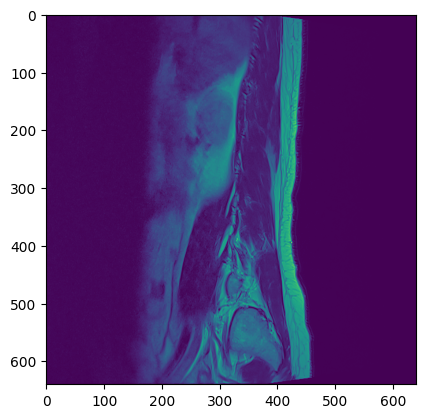

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/2.dcm


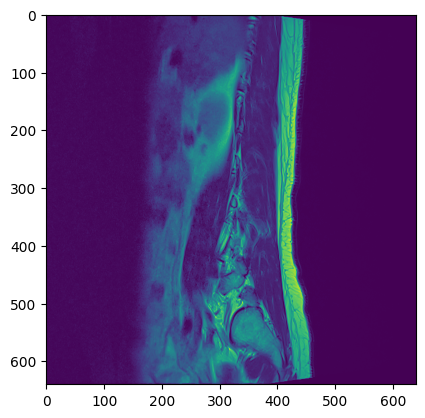

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/3.dcm


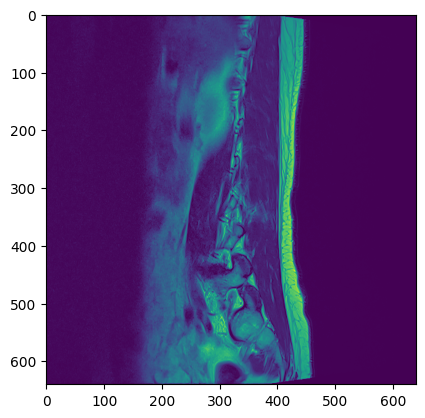

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/4.dcm


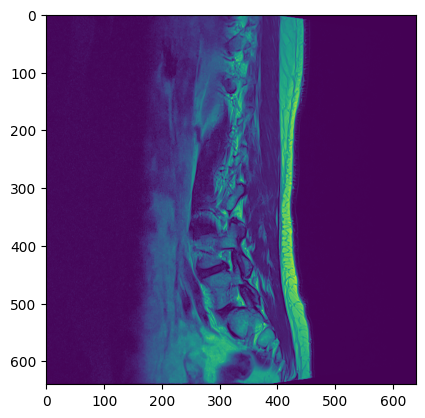

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/5.dcm


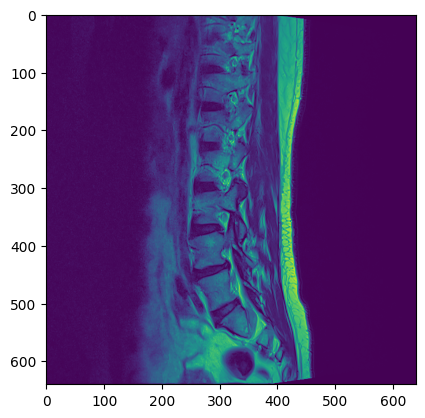

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/6.dcm


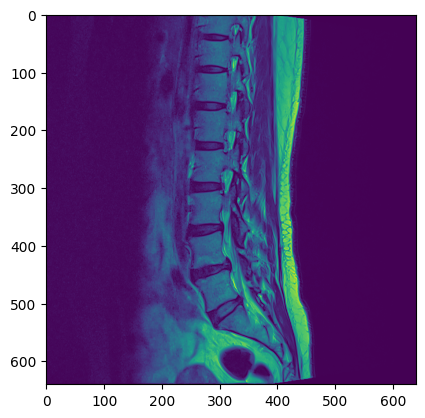

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/7.dcm


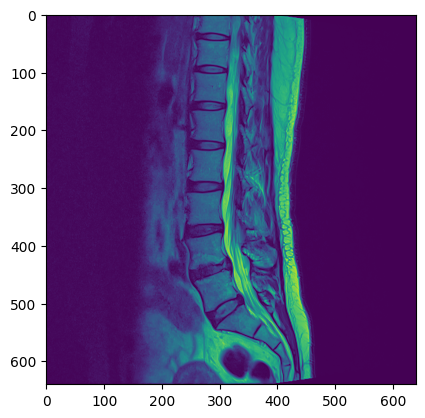

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm


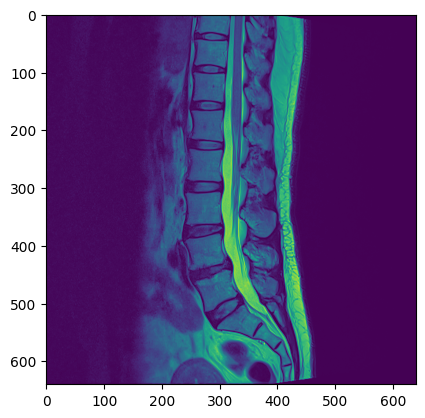

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/9.dcm


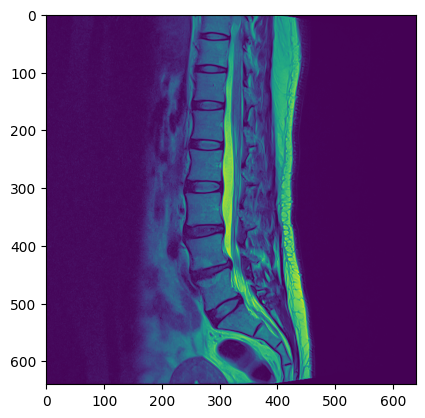

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/10.dcm


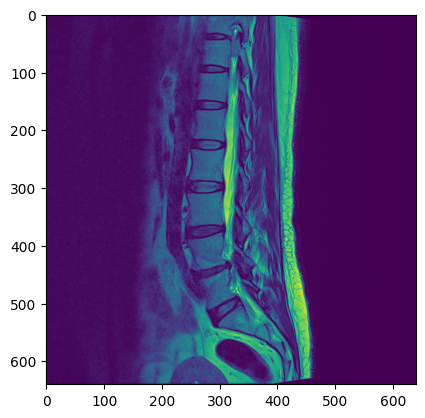

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/11.dcm


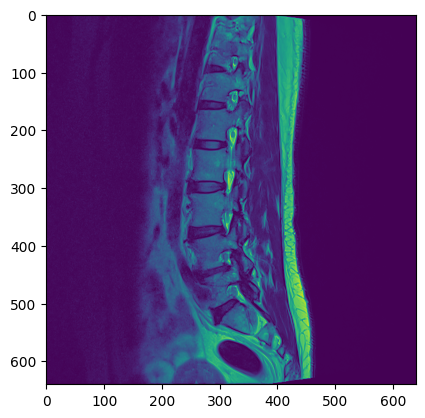

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/12.dcm


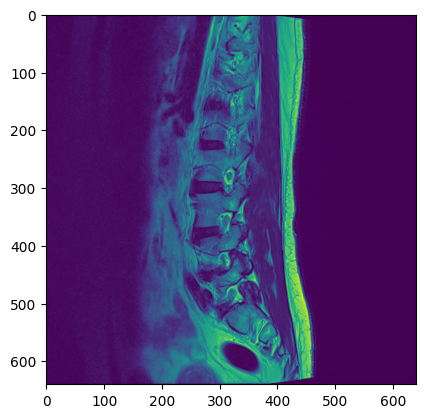

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/13.dcm


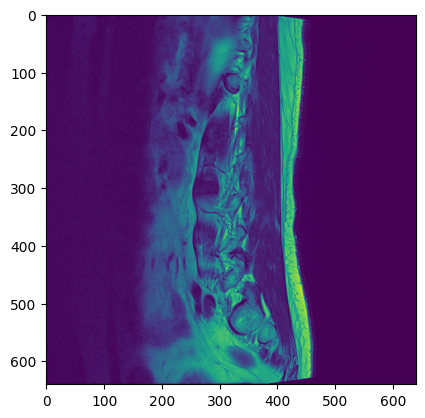

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/14.dcm


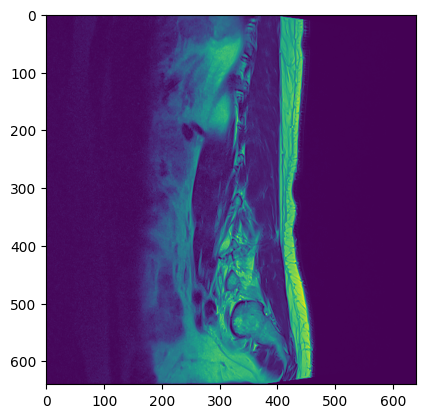

../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/15.dcm


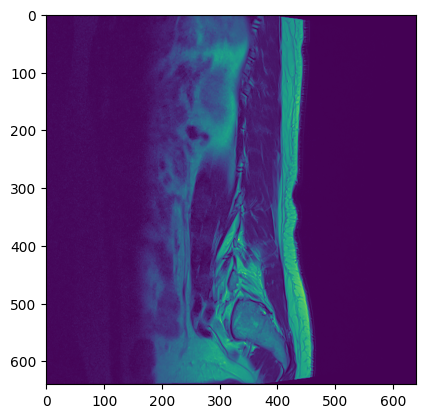

In [33]:
for i in range(1,15+1):
    my_file = my_path + str(i) + '.dcm'
    print(my_file)
    # load image
    ds = dicom.dcmread(my_file)
    # and plot
    plt.imshow(ds.pixel_array)
    plt.show()

In [34]:
# preview test data
df_test_desc.head()

study_id   series_id series_description
0  44036939  2828203845        Sagittal T1
1  44036939  3481971518           Axial T2
2  44036939  3844393089   Sagittal T2/STIR

In [35]:
# preview sample submission
df_sub.head()

row_id  normal_mild  moderate  \
0  44036939_left_neural_foraminal_narrowing_l1_l2     0.333333  0.333333   
1  44036939_left_neural_foraminal_narrowing_l2_l3     0.333333  0.333333   
2  44036939_left_neural_foraminal_narrowing_l3_l4     0.333333  0.333333   
3  44036939_left_neural_foraminal_narrowing_l4_l5     0.333333  0.333333   
4  44036939_left_neural_foraminal_narrowing_l5_s1     0.333333  0.333333   

     severe  
0  0.333333  
1  0.333333  
2  0.333333  
3  0.333333  
4  0.333333

In [36]:
# setup baseline model just using observed frequencies
n = df_sub.shape[0]
for i in range(0,n):
    # extract label from id
    current_label = df_sub.loc[i, 'row_id'].split('_',1)[1]
    # look up frequencies in frequency table
    p1 = freqs.loc[freqs.label==current_label, 'p1'].min()
    p2 = freqs.loc[freqs.label==current_label, 'p2'].min()
    p3 = freqs.loc[freqs.label==current_label, 'p3'].min()
    # transfer results to submission table
    df_sub.loc[i, 'normal_mild'] = p1
    df_sub.loc[i, 'moderate'] = p2
    df_sub.loc[i, 'severe'] = p3

In [37]:
# preview
df_sub

row_id  normal_mild  moderate  \
0    44036939_left_neural_foraminal_narrowing_l1_l2     0.967055  0.031931   
1    44036939_left_neural_foraminal_narrowing_l2_l3     0.907755  0.086670   
2    44036939_left_neural_foraminal_narrowing_l3_l4     0.771414  0.208312   
3    44036939_left_neural_foraminal_narrowing_l4_l5     0.610238  0.318804   
4    44036939_left_neural_foraminal_narrowing_l5_s1     0.632032  0.263558   
5         44036939_left_subarticular_stenosis_l1_l2     0.933186  0.051353   
6         44036939_left_subarticular_stenosis_l2_l3     0.821447  0.134707   
7         44036939_left_subarticular_stenosis_l3_l4     0.671400  0.230223   
8         44036939_left_subarticular_stenosis_l4_l5     0.449797  0.316430   
9         44036939_left_subarticular_stenosis_l5_s1     0.716904  0.208248   
10  44036939_right_neural_foraminal_narrowing_l1_l2     0.961362  0.032028   
11  44036939_right_neural_foraminal_narrowing_l2_l3     0.911540  0.085409   
12  44036939_right_neural_foraminal_narrowing_l3_l4     0.768683  0.210473   
13  44036939_right_neural_foraminal_narrowing_l4_l5     0.614133  0.319776   
14  44036939_right_neural_foraminal_narrowing_l5_s1     0.651246  0.252161   
15       44036939_right_subarticular_stenosis_l1_l2     0.926130  0.060639   
16       44036939_right_subarticular_stenosis_l2_l3     0.833069  0.128368   
17       44036939_right_subarticular_stenosis_l3_l4     0.670046  0.230106   
18       44036939_right_subarticular_stenosis_l4_l5     0.451597  0.315256   
19       44036939_right_subarticular_stenosis_l5_s1     0.710874  0.201220   
20             44036939_spinal_canal_stenosis_l1_l2     0.955420  0.033941   
21             44036939_spinal_canal_stenosis_l2_l3     0.896657  0.076494   
22             44036939_spinal_canal_stenosis_l3_l4     0.821682  0.116515   
23             44036939_spinal_canal_stenosis_l4_l5     0.750760  0.120061   
24             44036939_spinal_canal_stenosis_l5_s1     0.964539  0.025836   

      severe  
0   0.001014  
1   0.005575  
2   0.020274  
3   0.070958  
4   0.104410  
5   0.015461  
6   0.043846  
7   0.098377  
8   0.233773  
9   0.074847  
10  0.006609  
11  0.003050  
12  0.020844  
13  0.066090  
14  0.096594  
15  0.013230  
16  0.038563  
17  0.099848  
18  0.233147  
19  0.087907  
20  0.010638  
21  0.026849  
22  0.061803  
23  0.129179  
24  0.009625

In [38]:
# save submission file
df_sub.to_csv('submission_freq.csv', index=False)

In [39]:
# simple version, just fixed values
n = df_sub.shape[0]
for i in range(0,n):
    df_sub.loc[i, 'normal_mild'] = 0.34
    df_sub.loc[i, 'moderate'] = 0.33
    df_sub.loc[i, 'severe'] = 0.33

In [40]:
# save submission file
df_sub.to_csv('submission.csv', index=False)